In [1]:
import sys, os
sys.path.insert(1,os.path.join("..",".."))

import fmdtools.faultsim.propagate as propagate
import fmdtools.resultdisp as rd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from drone_mdl import *
import time

In [2]:
from drone_opt import *

Example model and parameters:

In [3]:
params={'start': [0.0,0.0, 10, 10], 'target': [0, 150, 160, 160], 'safe': [0, 50, 10, 10], # areas
        'flightplan':{ 1:[0,0,50], 2:[100, 200, 50], 3:[100, 100, 85], 4:[-25, 150, 20],5:[75, 300, 20],6:[0, 300, 20], 7:[0,0,50], 8:[0,0,0] },
        'landtime': 12,
        'loc':'rural',
        'bat':'series-split',                           #'monolithic', 'series-split', 'paralel-split', 'split-both'
        'linearch':'quad',                              #quad, hex, oct
        'respolicy':{'bat':'emland','line':'emland'}}   #continue, to_home, to_nearest, emland
mdl = Drone(params=params)

### Model Overview

In [4]:
#%matplotlib qt - unnecessary--already set in model
# pos = rd.graph.set_pos(mdl, gtype='bipartite')
# %matplotlib inline

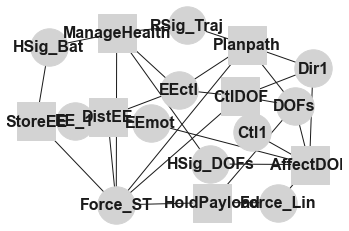

In [5]:
fig, ax = rd.graph.show(mdl, gtype='bipartite', scale=2.0)

In [6]:
fig.savefig('modelstructure.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

### Design model

The drone model has 4 possible battery architectures: monolithic, series-split, parallel-split, and split-both. Each of these architectures enable some reconfiguration of the battery in case of faults but also add design cost, and (more importantly), weight. 

The drone model also has 3 possible line architectures (quadrotor, hexarotor, and octorotor) which increase design resilience but also lead to both increased design cost, weight, and drag.

The cost of a model can be tabulated using `calc_des` in `drone_opt`.

In [7]:
calc_des(mdl)

300

To get the objective in terms of the design vector $x_{des}$, use `x_to_descost`.

In [8]:
x_des = [1,0]

In [9]:
x_to_dcost(x_des)

300

### Operational model

The drone model has 1 operational variable - the flight height. This variable determines how high the drone flies and thus how detailed of an image it can caputure. Based on this height, a flightplan is determined.

The operational model models the function of the battery, motors, and trajectory of the craft over time, as shown:

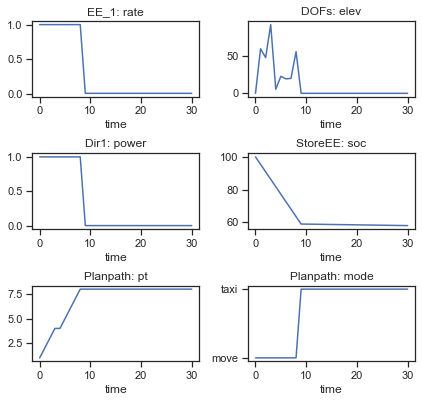

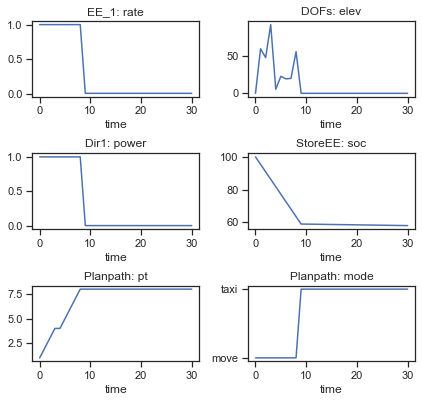

In [10]:
endresults_nom, resgraph, mdlhist =propagate.nominal(mdl)
rd.plot.mdlhistvals(mdlhist,fxnflowvals={'StoreEE':'soc', 'EE_1':'rate', 'DOFs': 'elev', 'Planpath':['mode', 'pt'], 'Dir1':'power'})

# put a constraint on battery health

The flightplan generated for this model is shown below. As shown, the drone flies through the arbitrary points set in the flightplan. Optimizing this sequence of points is a difficult problem, so instead we fly through a set pattern to cover the entire viewable area

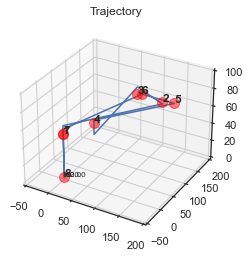

In [11]:
plot_nomtraj(mdlhist, params)

In [12]:
x=[0,0,55,1,1] # height is the third parameter -- 55
mdl = x_to_mdl(x)
endresults_nom, resgraph, mdlhist =propagate.nominal(mdl)

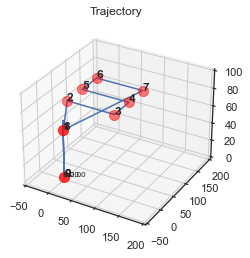

In [13]:
plot_nomtraj(mdlhist, mdl.params)

We can then see how this plan covers the space of points to view. As shown, the target area is shown in red and the points viewed are red while the unviewed points are grey. 

The drone flies from an initial landing location, flies over the target location, and then flies back. If there is a problem, there is also a designated land point that the drone can also fly to.

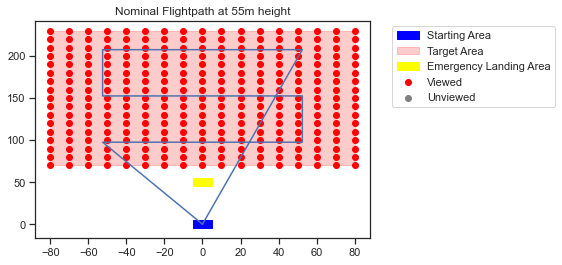

In [14]:
plot_xy(mdlhist, endresults_nom, title='Nominal Flightpath at 55m height', legend=True)

This flight plan changes depending on operational height, as shown:

In [15]:
mdl_low = x_to_mdl([1,1,50,1,1])
endresults_low, resgraph, mdlhist_low =propagate.nominal(mdl_low)

In [16]:
mdl_med = x_to_mdl([1,1,80,1,1])
endresults_med, resgraph, mdlhist_med =propagate.nominal(mdl_med)

In [17]:
mdl_hi = x_to_mdl([1,1,180,1,1])
endresults_hi, resgraph, mdlhist_hi =propagate.nominal(mdl_hi)

C:\Users\dhulse\Documents\GitHub\fmdtools\multirotor example\optimization paper demonstration\drone_opt.py:255: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(np.ceil((num_plots+1)/cols),cols,n, label='legend')


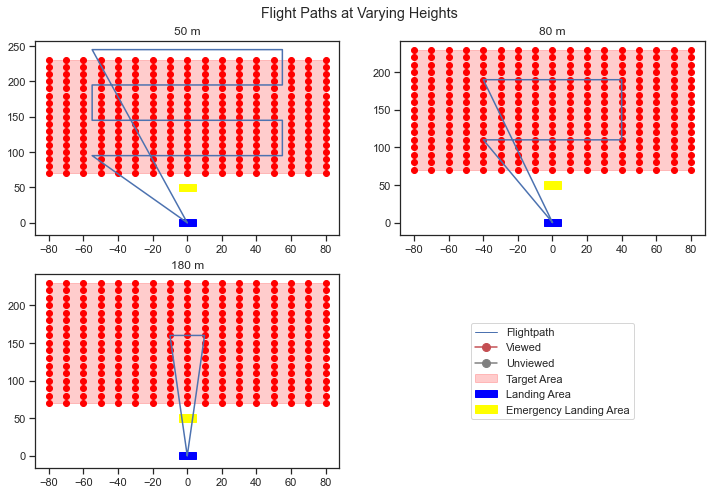

In [18]:
fig = plot_xys({'50 m':mdlhist_low ,'80 m': mdlhist_med , '180 m': mdlhist_hi}, {'80 m': endresults_med , '50 m':endresults_low , '180 m': endresults_hi}, legend=True, title="Flight Paths at Varying Heights", retfig=True)

In [19]:
fig.savefig('flightplans.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

The cost of a model is tabulated using `calc_oper` in `drone_opt`, along with the value of constraints:
- battery max discharge (20%)
- existence of faults
- max height (122 m per FAA regulation)

In [20]:
calc_oper(mdl)

(-9969116.59948255, -36.102377155008725, False, 0)

This operational cost and constraint values can be optimized in terms of design and operational variables $x_{des}$ and $x_{oper}$ using `x_to_ocost`.

In [21]:
x_oper = [90]

In [22]:
x_to_ocost(x_des, x_oper)

(-10957136.282944445, -42.41266043897626, False, 0)

### Resilience model

The resilience model has two variables--the battery resilience policy, and the line resilience policy, which each determine how the flight plan changes based on faults detected in the battery and line, respectively.

The resilience cost of a model can be calculated using `calc_res`.

In [23]:
rescost = calc_res(mdl)

SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 35.76it/s]


In [24]:
rescost

-9958232.517042963

This can be calculated in terms of the design, operational, and variables $x_{des}$, $x_{oper}$, and $x_{res}$ using `x_to_rcost`

In [25]:
x_res = [0,0]

In [26]:
rescost = x_to_rcost(x_des, x_oper, x_res)

SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 30.34it/s]


In [27]:
rescost

-10946594.510396076

Table of fault scenanios in urban flight scenario:

In [28]:
mdl = x_to_mdl([0,0, 30, 0,0], loc='urban')
a,b,c,d = calc_oper(mdl)

In [29]:
app = SampleApproach(mdl, faults='single-component', phases={'forward'})
endclasses, mdlhists = propagate.approach(mdl, app, staged=True)

SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.62it/s]


In [30]:
endclasses['ManageHealth falsemasking, t=7.0']

{'rate': 9.333333333333334e-08,
 'cost': 2354.8587137588097,
 'expected cost': 21.978681328415558,
 'repcost': 1000,
 'landcost': 0,
 'safecost': 1500,
 'viewed value': 145.1412862411902,
 'viewed': {(-80, 70): 0.0010935444016918405,
  (-80, 80): 0.0010935444016918405,
  (-80, 90): 0.0010935444016918405,
  (-80, 100): 0.0011112533346389944,
  (-80, 110): 0.0011112533346389944,
  (-80, 120): 0.0011112533346389944,
  (-80, 130): 0.0011111167876760406,
  (-80, 140): 0.0011111167876760406,
  (-80, 150): 0.0011111167876760406,
  (-80, 160): 0.0011111110532543223,
  (-80, 170): 0.0011111110532543223,
  (-80, 180): 0.0011111110532543223,
  (-80, 190): 0.0011111111078676557,
  (-80, 200): 0.0011111111078676557,
  (-80, 210): 0.0011111111078676557,
  (-80, 220): 0.001111111099129522,
  (-80, 230): 0.0011111110986926122,
  (-70, 70): 0.0010935444016918405,
  (-70, 80): 0.0010935444016918405,
  (-70, 90): 0.0010935444016918405,
  (-70, 100): 0.0011112533346389944,
  (-70, 110): 0.0011112533346389

In [31]:
simplefmea = rd.tabulate.simplefmea(endclasses)
simplefmea

,rate,cost,expected cost,repcost,landcost,safecost,viewed value,viewed,landloc,body strikes,head strikes,property restrictions,severities,unsafe flight time
"ManageHealth falsemasking, t=7.0",0.0,2354.858714,21.978681,1000,0,1500,145.141286,"{(-80, 70): 0.0010935444016918405, (-80, 80): ...",nominal,0,0,0,"{'hazardous': 0.0, 'minor': 9.333333333333334e...",15
"ManageHealth falseemland, t=7.0",0.0,2354.858714,10.989341,1000,0,1500,145.141286,"{(-80, 70): 0.0010935444016918405, (-80, 80): ...",nominal,0,0,0,"{'hazardous': 0.0, 'minor': 4.666666666666667e...",15
"ManageHealth lostfunction, t=7.0",0.0,2354.858714,8.242005,1000,0,1500,145.141286,"{(-80, 70): 0.0010935444016918405, (-80, 80): ...",nominal,0,0,0,"{'hazardous': 0.0, 'minor': 3.4999999999999996...",15
"StoreEE nocharge, t=7.0",0.000009,15434.21024,14405.26289,100,10000,5400.0,65.78976,"{(-80, 70): 0.0010935444016918405, (-80, 80): ...",over target,0.0003,0.0002,1,"{'hazardous': 9.32866822183313e-09, 'minor': 9...",6
"StoreEE lowcharge, t=7.0",0.000033,15634.21024,51071.753449,200,10000,5500.0,65.78976,"{(-80, 70): 0.0010935444016918405, (-80, 80): ...",over target,0.0003,0.0002,1,"{'hazardous': 3.265033877641595e-08, 'minor': ...",7
"StoreEE S1P1short, t=7.0",0.000016,15434.21024,24008.771484,100,10000,5400.0,65.78976,"{(-80, 70): 0.0010935444016918405, (-80, 80): ...",over target,0.0003,0.0002,1,"{'hazardous': 1.5547780369721885e-08, 'minor':...",6
"StoreEE S1P1degr, t=7.0",0.000016,15434.21024,24008.771484,100,10000,5400.0,65.78976,"{(-80, 70): 0.0010935444016918405, (-80, 80): ...",over target,0.0003,0.0002,1,"{'hazardous': 1.5547780369721885e-08, 'minor':...",6
"StoreEE S1P1break, t=7.0",0.000016,15434.21024,24008.771484,100,10000,5400.0,65.78976,"{(-80, 70): 0.0010935444016918405, (-80, 80): ...",over target,0.0003,0.0002,1,"{'hazardous': 1.5547780369721882e-08, 'minor':...",6
"StoreEE S1P1nocharge, t=7.0",0.000028,15434.21024,43215.788671,100,10000,5400.0,65.78976,"{(-80, 70): 0.0010935444016918405, (-80, 80): ...",over target,0.0003,0.0002,1,"{'hazardous': 2.7986004665499388e-08, 'minor':...",6
"DistEE short, t=7.0",0.000002,15634.21024,3647.982389,300,10000,5400.0,65.78976,"{(-80, 70): 0.0010935444016918405, (-80, 80): ...",over target,0.0003,0.0002,1,"{'hazardous': 2.3321670554582825e-09, 'minor':...",6


In [32]:
scentable = simplefmea[[ 'rate', 'unsafe flight time', 'landloc','cost']]
scentable

,rate,unsafe flight time,landloc,cost
"ManageHealth falsemasking, t=7.0",0.0,15,nominal,2354.858714
"ManageHealth falseemland, t=7.0",0.0,15,nominal,2354.858714
"ManageHealth lostfunction, t=7.0",0.0,15,nominal,2354.858714
"StoreEE nocharge, t=7.0",0.000009,6,over target,15434.21024
"StoreEE lowcharge, t=7.0",0.000033,7,over target,15634.21024
"StoreEE S1P1short, t=7.0",0.000016,6,over target,15434.21024
"StoreEE S1P1degr, t=7.0",0.000016,6,over target,15434.21024
"StoreEE S1P1break, t=7.0",0.000016,6,over target,15434.21024
"StoreEE S1P1nocharge, t=7.0",0.000028,6,over target,15434.21024
"DistEE short, t=7.0",0.000002,6,over target,15634.21024


In [33]:
print(scentable.to_latex())

\begin{tabular}{lllll}
\toprule
{} &      rate & unsafe flight time &      landloc &         cost \\
\midrule
ManageHealth falsemasking, t=7.0 &       0.0 &                 15 &      nominal &  2354.858714 \\
ManageHealth falseemland, t=7.0  &       0.0 &                 15 &      nominal &  2354.858714 \\
ManageHealth lostfunction, t=7.0 &       0.0 &                 15 &      nominal &  2354.858714 \\
StoreEE nocharge, t=7.0          &  0.000009 &                  6 &  over target &  15434.21024 \\
StoreEE lowcharge, t=7.0         &  0.000033 &                  7 &  over target &  15634.21024 \\
StoreEE S1P1short, t=7.0         &  0.000016 &                  6 &  over target &  15434.21024 \\
StoreEE S1P1degr, t=7.0          &  0.000016 &                  6 &  over target &  15434.21024 \\
StoreEE S1P1break, t=7.0         &  0.000016 &                  6 &  over target &  15434.21024 \\
StoreEE S1P1nocharge, t=7.0      &  0.000028 &                  6 &  over target &  15434.21024 \\

In [34]:
sum(scentable["rate"][0:2]) + sum(scentable["rate"][8:11]) + sum(scentable["rate"][15:])

1.000055517777778

In [35]:
(sum(scentable["cost"][0:2]) + sum(scentable["cost"][8:11]) + sum(scentable["cost"][15:]))/11

17272.340681224563

In [36]:
scentable["rate"][15:]

AffectDOF RFmechbreak, t=7.0       0.000003
AffectDOF RFmechfriction, t=7.0    0.000002
AffectDOF RFstuck, t=7.0           0.000001
CtlDOF noctl, t=7.0                0.000001
CtlDOF degctl, t=7.0               0.000006
Planpath noloc, t=7.0              0.000001
Planpath degloc, t=7.0             0.000006
HoldPayload break, t=7.0                0.0
HoldPayload deform, t=7.0          0.000001
nominal                                 1.0
Name: rate, dtype: object

The model can also be queried in terms of the entire design vector using `x_to_mdl` and `x_to_cost`:

In [37]:
x=[0,2,100,1,1]

In [38]:
mdl = x_to_mdl(x)

In [39]:
cost, constraints = x_to_cost(x)

SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 32.26it/s]


In [40]:
cost

-21894739.12195334

In [41]:
constraints

(-12.78499278499281, False, 0)

### Exploring design trade-offs


Octocopter performance

In [42]:
x=[0,2,100,1,1]
mdl = x_to_mdl(x)
endresults,resgraph,mdlhist = propagate.nominal(mdl)

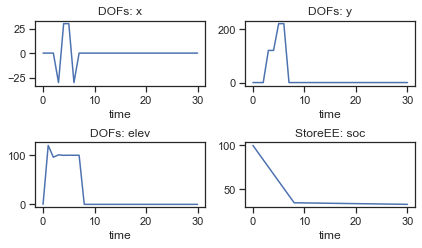

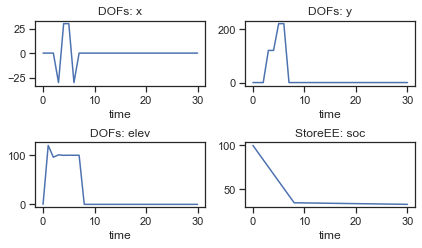

In [43]:
rd.plot.mdlhistvals(mdlhist, fxnflowvals={'StoreEE':['soc'], 'DOFs':['x', 'y', 'elev']})

Quadcopter performance

In [44]:
x=[0,0,100,1,1]
mdl = x_to_mdl(x)
endresults,resgraph,mdlhist = propagate.nominal(mdl)

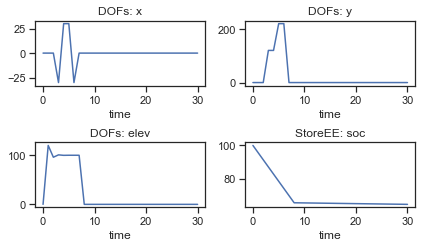

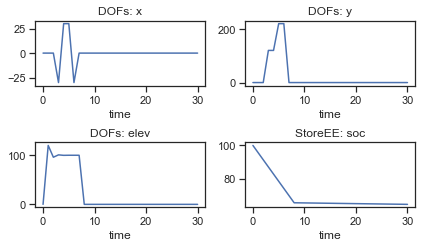

In [45]:
rd.plot.mdlhistvals(mdlhist, fxnflowvals={'StoreEE':['soc'], 'DOFs':['x', 'y', 'elev']})

As shown, over the same flight with the same parameters, the quadcopter has a higher state of charge. Thus, as shown below, it can fly lower, resulting in a longer mission while ending at the same state of charge.

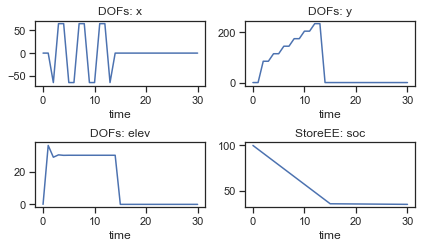

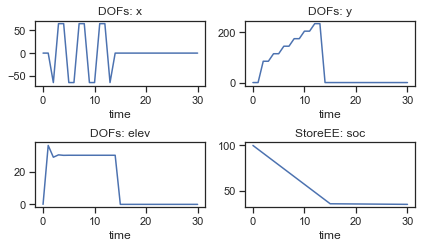

In [46]:
x=[0,0,30,1,1]
mdl = x_to_mdl(x)
endresults,resgraph,mdlhist = propagate.nominal(mdl)
rd.plot.mdlhistvals(mdlhist, fxnflowvals={'StoreEE':['soc'], 'DOFs':['x', 'y', 'elev']})

### Trade-off plotting

In [47]:
explore_tradoffs(loc='urban', filename='tradeoffs_urban.csv')

Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.07it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 33.40it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.68it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.54it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 29.75it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.42it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.81it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.37it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.87it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.17it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.01it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.88it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 17.19it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 29.27it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.74it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 18.92it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 26.80it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.10it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.82it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.17it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.67it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.96it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.07it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.47it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.75it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 30.13it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.59it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.28it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.38it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.91it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.86it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.32it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.53it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.52it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.38it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 26.21it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 16.91it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 29.20it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.77it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 18.23it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 26.68it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.42it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.01it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 18.82it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.90it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.67it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.75it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.89it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.28it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 35.75it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.77it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.47it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 32.73it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.86it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.90it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.92it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.99it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.70it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.21it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 30.89it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.79it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 30.22it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.96it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.55it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 32.67it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.52it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.30it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.07it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.09it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.10it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.46it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 30.44it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.27it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 32.99it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.06it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.85it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 30.54it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.58it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.49it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.99it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.51it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.30it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.04it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 28.83it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.88it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 33.93it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.30it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.41it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 31.46it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.67it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.10it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.28it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.94it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.48it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.17it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 30.49it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.51it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 34.13it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.21it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.84it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 32.82it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.49it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.87it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.38it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.10it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.69it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.82it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 30.90it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.42it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 33.05it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.61it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.46it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 32.03it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.28it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.58it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.34it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.77it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.39it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.20it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 29.93it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.60it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 33.01it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.94it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.96it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 30.49it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.04it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.27it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.32it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.04it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.54it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.65it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 28.47it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.54it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 32.34it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.69it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.36it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 31.03it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.20it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.57it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.84it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.49it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.28it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.22it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 28.10it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.70it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 35.92it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.36it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.83it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 30.31it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.41it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.26it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.12it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.15it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.69it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.51it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 31.12it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.40it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 32.02it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.29it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.07it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 29.38it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.22it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.28it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.97it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.84it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.93it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 26.53it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 29.28it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.06it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 32.27it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.85it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.53it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 31.82it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.35it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.59it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.45it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.88it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.11it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 26.59it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S1P2lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 30.02it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.53it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 31.45it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.67it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.08it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 28.64it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.55it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.08it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.12it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.18it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1nocharge', 'S1P1lowcharge', 'S2P1nocharge', 'S2P2nocharge', 'S2P1lowcharge', 'S1P2nocharge', 'S1P2lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.80it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.93it/s]


Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S2P2lowcharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S1P2lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 28.41it/s]


,Bat,Rotor,Height,ResPolBat,ResPolRot,desC,operC,resC,c1,c2,c3,c_cum
0,0,0,10,0,0,0,217288480.968541,217324040.143564,1,1,0,1
1,0,0,20,0,0,0,4405679.139062,4440441.253083,1,1,0,1
2,0,0,30,0,0,0,-7514128.433301,-7479702.302299,0,0,0,0
3,0,0,40,0,0,0,-9486072.663138,-9461473.739573,0,0,0,0
4,0,0,50,0,0,0,-9473092.653583,-9448643.575258,0,0,0,0
5,0,0,60,0,0,0,-9966062.847379,-9943999.030773,0,0,0,0
6,0,0,70,0,0,0,-9961801.446547,-9939822.600163,0,0,0,0
7,0,0,80,0,0,0,-10959031.939716,-10941796.64744,0,0,0,0
8,0,0,90,0,0,0,-10957136.282944,-10939970.228323,0,0,0,0
9,0,0,100,0,0,0,-10955780.447687,-10938683.631967,0,0,0,0


Text(0.5, 1.08, 'Exploration of Design Variables')

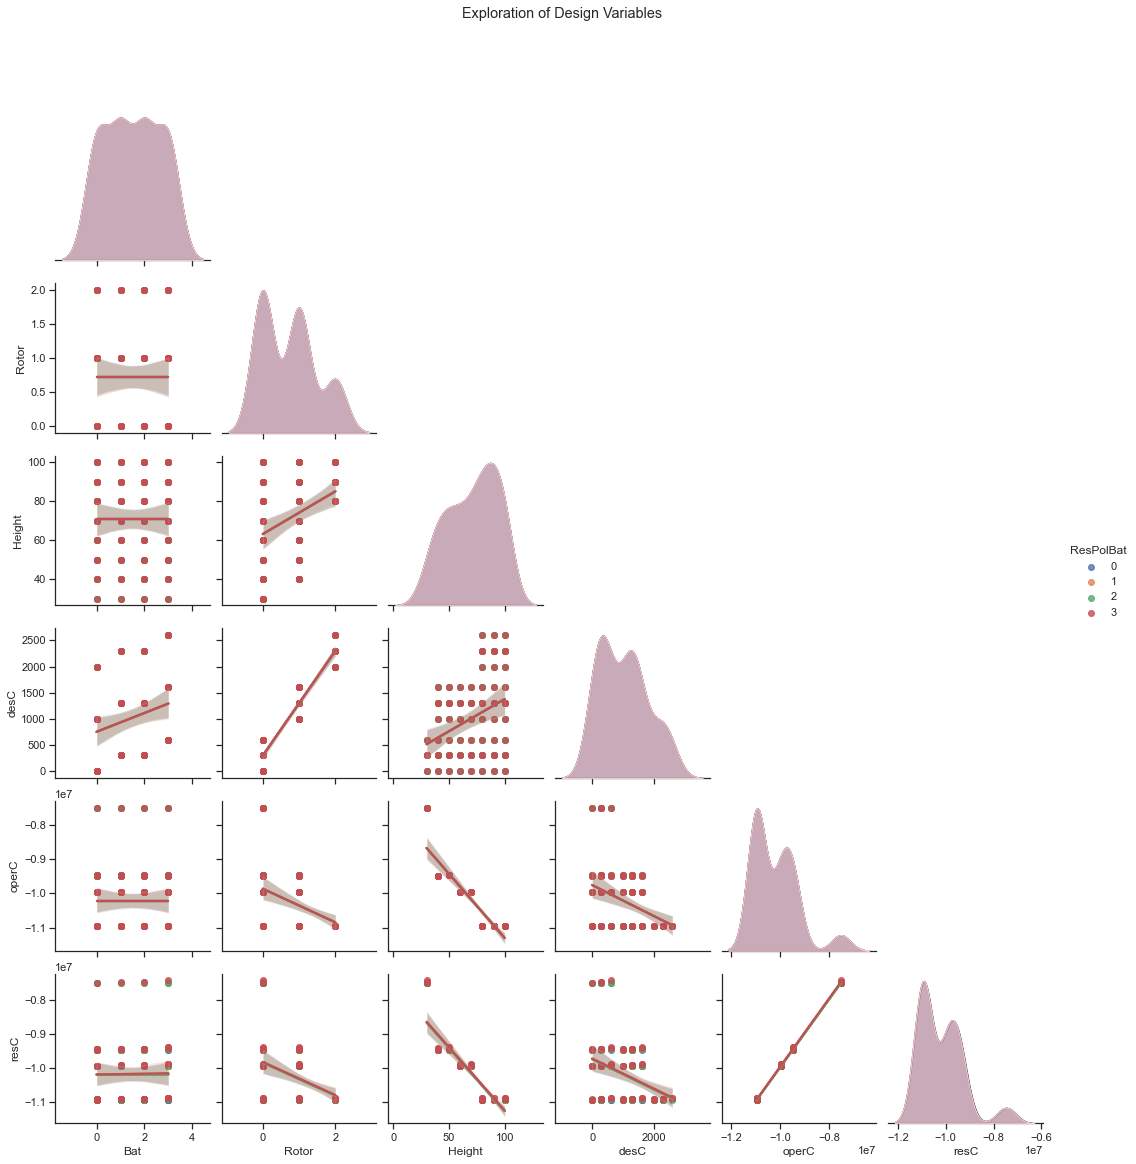

In [48]:
# Read the dataset of cost model values and constraint validation for a large grid of design variables
grid_results= pd.read_csv('tradeoffs_urban.csv')
#print(grid_results.head())
#print(grid_results.shape)

# Portion of feasible data among the whole dataset
feasible_DS =(grid_results['c_cum'].isin([0]).sum())/len(grid_results)
#print("The portion of feasible design space from the grid results")
#print(feasible_DS)

#Subsetting only feasible data
grid_results_FS = grid_results[(grid_results['c_cum']==0)]
g = sns.pairplot(grid_results_FS, hue="ResPolBat", vars=["Bat", "Rotor","Height","desC","operC","resC"], corner=True, diag_kind="kde",kind="reg")
g.fig.suptitle("Exploration of Design Variables", y=1.08)

In [49]:
g.fig.savefig('tradeoffs.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

### Optimization/plotting

### all-in-one search and pareto plotting

brute-force search of the space:

In [ ]:
results, opthist_rural, evals, ftime = brute_search(loc='rural')

resultstab = pd.DataFrame(results)
resultstab.columns = resultstab.columns.to_flat_index()
resultstab.to_csv('fullspace_rural.csv')

Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.39it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.64it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.50it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.26it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.20it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.80it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.87it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.10it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.13it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.78it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.46it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.02it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.86it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.79it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.14it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.27it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.16it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.19it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.41it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.97it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.20it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.62it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.48it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.19it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.43it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.51it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.38it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.12it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.33it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.76it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.59it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 36.31it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.13it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.94it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.88it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.30it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.61it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.40it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.37it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.05it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.50it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.41it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.53it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.75it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.62it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.88it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.93it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.03it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.34it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.01it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.69it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.23it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.88it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.34it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.87it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.35it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.97it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.34it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.83it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.85it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.27it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.70it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.57it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.71it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.56it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.92it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.88it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.96it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.23it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.18it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.23it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.64it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.05it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.10it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.25it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.18it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.35it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.02it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.25it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 33.19it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.50it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.19it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.88it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.99it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.18it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.88it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.41it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.52it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.79it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.20it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.51it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.12it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.85it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.98it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.88it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.02it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.32it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.17it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.07it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.78it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.26it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.93it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.26it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.20it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.46it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.28it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.24it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.03it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.01it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.78it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.37it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.92it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.66it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.38it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.72it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.85it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.00it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.27it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.34it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.95it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.98it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.43it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.11it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.80it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.92it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.22it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.60it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.13it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.90it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.84it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.82it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.65it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.98it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.98it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.27it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.87it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.90it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.53it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.94it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.69it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.57it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.23it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.28it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.40it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.83it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.46it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.45it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.00it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.06it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.25it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.53it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.61it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.39it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.41it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.54it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.30it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.81it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.95it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.17it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.70it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.97it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.23it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.60it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.58it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 26.15it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.76it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 28.00it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.45it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.52it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.48it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.63it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.84it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.53it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 28.16it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 28.17it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 28.08it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.34it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 26.87it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.31it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.19it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 24.88it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.13it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.56it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.22it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 25.43it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.01it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.63it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 27.44it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 26.06it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 28.11it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 28.43it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 32.00it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 17.76it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 18.32it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 18.00it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 17.30it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.65it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.67it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.83it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.47it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.28it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.09it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.16it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.34it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.57it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.01it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.84it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.43it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 18.24it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.15it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.08it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 18.83it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.63it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.20it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.87it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.83it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.14it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.43it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.02it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.77it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.55it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.74it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.95it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 32.78it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.82it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.19it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.69it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 18.81it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.64it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.56it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.12it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.50it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.99it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.50it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.59it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.03it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.30it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.05it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.06it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.94it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.33it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.10it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.97it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.81it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.04it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.24it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.97it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.54it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.92it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.24it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.55it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.57it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 18.67it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.09it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.30it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.07it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.33it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.15it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.49it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.77it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.77it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.62it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.44it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.16it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.88it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.46it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.84it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.51it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.69it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.63it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.49it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:00<00:00, 29.84it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.44it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.69it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.92it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.78it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.96it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.60it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.59it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.52it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.97it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.95it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.73it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.55it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.84it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.32it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.47it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.24it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.38it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.67it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.74it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.70it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.09it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.66it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.27it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.82it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.05it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.33it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.53it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.14it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.85it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.73it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.16it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 23.09it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.62it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.86it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.30it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 19.61it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.66it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.99it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.42it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.30it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.93it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.68it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.64it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.26it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.80it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.55it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.34it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.47it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.36it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.34it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.94it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.71it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.30it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.37it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.31it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.93it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.69it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.24it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.84it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.76it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.21it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.28it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.01it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.21it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 20.81it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 22.24it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.93it/s]


Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}
Faults found during the nominal run {'StoreEE': ['S1P1lowcharge', 'lowcharge', 'S2P1lowcharge']}


SCENARIOS COMPLETE: 100%|██████████| 24/24 [00:01<00:00, 21.58it/s]


Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}
Faults found during the nominal run {'StoreEE': ['S1P1nocharge', 'S1P1lowcharge', 'S2P1lowcharge', 'S2P1nocharge', 'nocharge']}


SCENARIOS COMPLETE:  67%|██████▋   | 16/24 [00:00<00:00, 19.55it/s]

In [ ]:
opthist_rural

In [ ]:
results, opthist_urban, evals, ftime = brute_search(loc='urban')

resultstab = pd.DataFrame(results)
resultstab.columns = resultstab.columns.to_flat_index()
resultstab.to_csv('fullspace_urban.csv')

In [ ]:
opthist_urban

In [ ]:
results, opthist_conj, evals, ftime = brute_search(loc='congested')

resultstab = pd.DataFrame(results)
resultstab.columns = resultstab.columns.to_flat_index()
resultstab.to_csv('fullspace_congested.csv')

In [ ]:
opthist_conj

load search results: 

In [ ]:
resultstab_rural = pd.read_csv('fullspace_rural.csv')
resultstab_rural = resultstab_rural.drop(labels='Unnamed: 0', axis=1)
resultstab_rural

Construct pareto front of design, operational, and resilience costs:

In [ ]:
pareto3 = get_3dpareto(resultstab_rural, 0,1,2)

In [ ]:
fig, ax = plot_pareto3(pareto3)

In [ ]:
ax.set_xlabel('$C_D$ (\$)')
ax.set_ylabel('$C_R$ (\$)')
ax.set_zlabel('$C_O$ (\$)')
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10
ax.dist = 12
#ax.set_title('Pareto Front in Rural Scenario')
ax.legend_.remove()
fig

In [ ]:
fig.savefig('pareto_dorcosts_rural.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [ ]:
resultstab_urban = pd.read_csv('fullspace_urban.csv')
resultstab_urban = resultstab_urban.drop(labels='Unnamed: 0', axis=1)
resultstab_urban

In [ ]:
pareto3_urban = get_3dpareto(resultstab_urban, 0,1,2)

In [ ]:
fig, ax = plot_pareto3(pareto3_urban)
ax.set_xlabel('$C_D$ (\$)')
ax.set_ylabel('$C_R$ (\$)')
ax.set_zlabel('$C_O$ (\$)')
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10
ax.dist = 12
#ax.set_title('Pareto Front in Urban Scenario')
ax.legend_.remove()
#fig.subplots_adjust(top=1, bottom=-0.2, left=-0.2, right=0.9)
fig

In [ ]:
fig.savefig('pareto_dorcosts_urban.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

In [ ]:
resultstab_congested = pd.read_csv('fullspace_congested.csv')
resultstab_congested = resultstab_congested .drop(labels='Unnamed: 0', axis=1)
resultstab_congested 

In [ ]:
pareto3_congested = get_3dpareto(resultstab_congested, 0,1,2)

In [ ]:
fig, ax = plot_pareto3(pareto3_congested)
ax.set_xlabel('$C_D$ (\$)')
ax.set_ylabel('$C_R$ (\$)')
ax.set_zlabel('$C_O$ (\$)')
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
ax.zaxis.labelpad=10
ax.dist = 12
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Equal-weight design'], loc='upper center')
#ax.set_title('Pareto Front in Congested Scenario')
fig

In [ ]:
fig.savefig('pareto_dorcosts_congested.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

Construct pareto front of Repair, Landing, and Flight Costs

In [ ]:
resilcosts = resultstab_urban[3:5]
flightcosts = resultstab_urban[5:7].sum()
resilcosts = resilcosts.append(flightcosts, ignore_index=True)

pareto3_resilience = get_3dpareto(resilcosts, 0,1,2)

In [ ]:
fig, ax = plot_pareto3(pareto3_resilience)
ax.set_xlabel('Repair Cost')
ax.set_ylabel('Landing Cost')
ax.set_zlabel('Flight Cost')
ax.set_title('Resilience Pareto Front in Urban Scenario')

In [ ]:
fig.savefig('pareto_resilcosts.pdf', format="pdf", bbox_inches = 'tight', pad_inches = 0.0)

### Comparison of Optimization Architectures

In [ ]:
comparison_tab = pd.DataFrame(columns=['Approach', 'X_opt', 'Total Cost', 'D/O Cost', 'Res. Cost', 'D/O Evals', 'Res. Evals', 'Comp. Time'])
comparison_tab

All-in-one Approach:

In [ ]:
results, opt_hist, num_evals, runtime = brute_search(loc = 'urban')

In [ ]:
x_to_cost([2,0,40,1,1], loc='urban')
#so, need to fix the bilevel frameworks--the AAO is getting to the true min while they are not

In [ ]:
aao_values = {'Approach':'All-in-one'}
aao_values['X_opt'] = opt_hist[-1][1]
aao_values['Total Cost'] = opt_hist[-1][0]
aao_values['D/O Cost'] = x_to_dcost(opt_hist[-1][1][0:2]) + x_to_ocost(opt_hist[-1][1][0:2], opt_hist[-1][1][2:3])[0]
aao_values['Res. Cost'] = x_to_rcost(opt_hist[-1][1][0:2], opt_hist[-1][1][2:3], opt_hist[-1][1][3:5], loc='urban')
aao_values['D/O Evals'] = num_evals
aao_values['Res. Evals'] = num_evals
aao_values['Comp. Time'] = runtime

comparison_tab = comparison_tab.append(aao_values, ignore_index=True)
comparison_tab

Bi-stage Approach:

In [ ]:
xdes_opt, xoper_opt, xres_opt, desC_opt, operC_opt, resC_opt, num_upper, num_lower, runtime = bistage_optimization(loc='urban')

In [ ]:
bistage_values = {'Approach': 'Bi-stage'}
bistage_values['X_opt'] = xdes_opt+xoper_opt+xres_opt
bistage_values['Total Cost'] = desC_opt+operC_opt[0]+resC_opt
bistage_values['D/O Cost'] = desC_opt+operC_opt[0]
bistage_values['Res. Cost'] = resC_opt
bistage_values['D/O Evals'] = num_upper
bistage_values['Res. Evals'] = num_lower
bistage_values['Comp. Time'] = runtime

comparison_tab = comparison_tab.append(bistage_values, ignore_index=True)
comparison_tab

Bi-level Approach:

In [ ]:
xdes_opt, xoper_opt, xres_opt, desC_opt, operC_opt, resC_opt, num_upper, num_lower, runtime = bilevel_optimization(loc='urban', decomp = False)

In [ ]:
bilevel_values = {'Approach': 'Bi-level'}
bilevel_values['X_opt'] = xdes_opt+xoper_opt+xres_opt
bilevel_values['Total Cost'] = desC_opt+operC_opt[0]+resC_opt
bilevel_values['D/O Cost'] = desC_opt+operC_opt[0]
bilevel_values['Res. Cost'] = resC_opt
bilevel_values['D/O Evals'] = num_upper
bilevel_values['Res. Evals'] = num_lower
bilevel_values['Comp. Time'] = runtime

comparison_tab = comparison_tab.append(bilevel_values, ignore_index=True)
comparison_tab

Bi-level Approach with lower-level decomposition:

In [ ]:
xdes_opt, xoper_opt, xres_opt, desC_opt, operC_opt, resC_opt, num_upper, num_lower, runtime = bilevel_optimization(loc='urban', decomp = True)

In [ ]:
bileveldecomp_values = {'Approach': 'Bi-level (Decomp)'}
bileveldecomp_values['X_opt'] = xdes_opt+xoper_opt+xres_opt
bileveldecomp_values['Total Cost'] = desC_opt+operC_opt[0]+resC_opt
bileveldecomp_values['D/O Cost'] = desC_opt+operC_opt[0]
bileveldecomp_values['Res. Cost'] = resC_opt
bileveldecomp_values['D/O Evals'] = num_upper
bileveldecomp_values['Res. Evals'] = num_lower
bileveldecomp_values['Comp. Time'] = runtime

comparison_tab = comparison_tab.append(bileveldecomp_values, ignore_index=True)
comparison_tab

In [ ]:
comparison_tab.to_csv('comparison_table.csv')

In [ ]:
print(comparison_tab.to_latex())

In [ ]:
xres_opt